In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,CuDNNLSTM
from tensorflow import keras
import string

In [57]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [58]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [59]:
import re
!pip install contractions
import contractions


i=0
for doc in train.comment_text:
    doc = doc.lower()
    doc=  re.sub(r"https?://\S+|www\.\S+",'', doc)  #Remove URLs from a sample string
    doc = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', doc) # clean url
    doc = re.sub(r'#(\w+)', '',doc)   # clean hashes
    doc = re.sub(r'[^\x00-\x7f]',r'', doc) #Remove non-ASCII characters 
    doc = re.sub(r'@(\w+)', '', doc)   # clean @
    doc = re.sub(r'<[^>]+>', '',doc)  # clean tags
    doc = re.sub(r'\d+', '',doc)      # clean digits
    doc=re.sub(r'<.*?>','',doc)
    doc = re.sub("#", " ",doc)
    doc = re.sub(":::", " ", doc)
    doc = re.sub("\n", " ",doc)
    doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
    punctuation = set(string.punctuation)  #remove the punctuation
    doc = "".join([p for p in doc if p not in punctuation])
    doc=contractions.fix(doc)
    train.comment_text[i]=doc
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [61]:
x=train["comment_text"]
y=train["Toxic"]

In [62]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=3,shuffle=True)

In [63]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [64]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(hub_layer)
bi_model.add(tf.keras.layers.Reshape((1,128)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64))) #lstm with 64 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_10 (Reshape)        (None, 1, 128)            0         
                                                                 
 dropout_16 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 128)           99328     
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              99328     
 nal)                                                

In [65]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=3, mode='auto', restore_best_weights=True)
history = bi_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 124ms/step - loss: 0.2688 - accuracy: 0.8860 - val_loss: 0.2342 - val_accuracy: 0.9099
Epoch 2/20
462/462 [==============================] - 56s 121ms/step - loss: 0.1331 - accuracy: 0.9493 - val_loss: 0.2618 - val_accuracy: 0.9099
Epoch 3/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0767 - accuracy: 0.9709 - val_loss: 0.3503 - val_accuracy: 0.9010
Epoch 4/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0508 - accuracy: 0.9801 - val_loss: 0.4375 - val_accuracy: 0.8983
Epoch 5/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0391 - accuracy: 0.9847 - val_loss: 0.4267 - val_accuracy: 0.8992
Epoch 6/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0301 - accuracy: 0.9882 - val_loss: 0.5037 - val_accuracy: 0.8992
Epoch 00006: early stopping


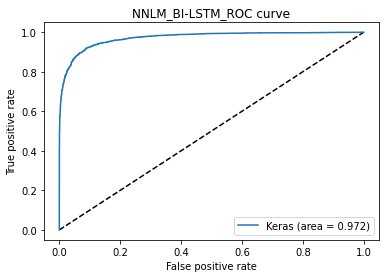

In [66]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_BI-LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [67]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.39977312
              precision    recall  f1-score   support

           0     0.9197    0.9124    0.9160      4154
           1     0.9109    0.9184    0.9146      4054

    accuracy                         0.9153      8208
   macro avg     0.9153    0.9154    0.9153      8208
weighted avg     0.9154    0.9153    0.9153      8208



In [68]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_11 (Reshape)        (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,161
Trainable params: 124,692,161
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 57s 120ms/step - loss: 0.1692 - accuracy: 0.9389 - val_loss: 0.2413 - val_accuracy: 0.9065
Epoch 2/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0814 - accuracy: 0.9687 - val_loss: 0.3330 - val_accuracy: 0.9010
Epoch 3/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0472 - accuracy: 0.9821 - val_loss: 0.4390 - val_accuracy: 0.8931
Epoch 4/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0297 - accuracy: 0.9886 - val_loss: 0.5719 - val_accuracy: 0.8898
Epoch 5/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0227 - accuracy: 0.9912 - val_loss: 0.6111 - val_accuracy: 0.8904
Epoch 6/20
462/462 [==============================] - 55s 118ms/step - loss: 0.0177 - accuracy: 0.9933 - val_loss: 0.6675 - val_accuracy: 0.8895
Epoch 00006: early stopping


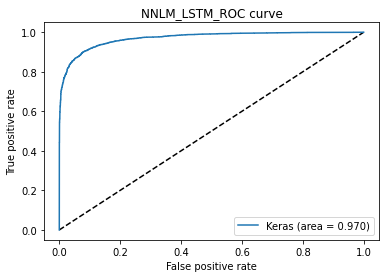

In [70]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [71]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.56127965
              precision    recall  f1-score   support

           0     0.9040    0.9225    0.9131      4154
           1     0.9189    0.8996    0.9091      4054

    accuracy                         0.9112      8208
   macro avg     0.9114    0.9110    0.9111      8208
weighted avg     0.9113    0.9112    0.9112      8208



In [72]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64,return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_12 (Reshape)        (None, 1, 128)            0         
                                                                 
 dropout_20 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_21 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 1)               

In [73]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 123ms/step - loss: 0.1163 - accuracy: 0.9622 - val_loss: 0.2920 - val_accuracy: 0.9056
Epoch 2/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0632 - accuracy: 0.9767 - val_loss: 0.3512 - val_accuracy: 0.8980
Epoch 3/20
462/462 [==============================] - 55s 119ms/step - loss: 0.0399 - accuracy: 0.9849 - val_loss: 0.4618 - val_accuracy: 0.8983
Epoch 4/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0271 - accuracy: 0.9898 - val_loss: 0.5606 - val_accuracy: 0.8937
Epoch 5/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0203 - accuracy: 0.9926 - val_loss: 0.5362 - val_accuracy: 0.8965
Epoch 6/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0166 - accuracy: 0.9939 - val_loss: 0.5936 - val_accuracy: 0.8913
Epoch 00006: early stopping


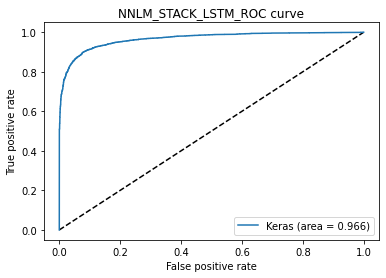

In [74]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_STACK_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [75]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.50632995
              precision    recall  f1-score   support

           0     0.9031    0.9220    0.9124      4154
           1     0.9183    0.8986    0.9084      4054

    accuracy                         0.9105      8208
   macro avg     0.9107    0.9103    0.9104      8208
weighted avg     0.9106    0.9105    0.9104      8208

